In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))  # 因为 dataset.py 在上一级目录

import numpy as np
from PIL import Image
import torchvision.transforms.functional as TF

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from skimage.feature import hog, local_binary_pattern
from dataset import create_dataloaders

## 加载数据并转灰度图像（适用于传统方法）

In [3]:
# 加载数据
train_loader, val_loader, test_loader, class_names = create_dataloaders(
    root_dir='Aerial_Landscapes',
    batch_size=32,
    augmentation_strategy='minimal',
    num_workers=0
)

# 将图像转换为灰度 numpy 格式
def extract_numpy_images(dataloader):
    images, labels = [], []
    for batch_imgs, batch_labels in dataloader:
        for img, label in zip(batch_imgs, batch_labels):
            img_pil = TF.to_pil_image(img).convert("L")
            img_np = np.array(img_pil)
            images.append(img_np)
            labels.append(label.item())
    return np.array(images), np.array(labels)

X_train_imgs, y_train = extract_numpy_images(train_loader)
X_test_imgs, y_test = extract_numpy_images(test_loader)

创建数据加载器，batch_size=32, split_ratio=[0.6, 0.2, 0.2], augmentation=minimal...
数据集大小 - 训练: 7200, 验证: 2400, 测试: 2400
训练集类别分布:
- Agriculture: 480张图像
- Airport: 480张图像
- Beach: 480张图像
- City: 480张图像
- Desert: 480张图像
- Forest: 480张图像
- Grassland: 480张图像
- Highway: 480张图像
- Lake: 480张图像
- Mountain: 480张图像
- Parking: 480张图像
- Port: 480张图像
- Railway: 480张图像
- Residential: 480张图像
- River: 480张图像


## 特征提取函数（支持 HOG 和 LBP）

In [5]:
def extract_features(images, method='HOG'):
    features = []
    for img in images:
        if method == 'HOG':
            feat = hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)
        elif method == 'LBP':
            lbp = local_binary_pattern(img, P=8, R=1, method='uniform')
            hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 59))
            feat = hist / np.sum(hist)
        features.append(feat)
    return np.array(features)

## 定义训练和评估函数

In [7]:
def train_and_evaluate(X_train, y_train, X_test, y_test, model, model_name):
    print(f"\n==== Model: {model_name} ====")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    #zero_division=0/1	快速抑制警告	不影响模型，仅调整指标计算方式
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=1))#未预测类别的 Precision 设为 1（保守处理，避免低估模型）
    
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        display_labels=class_names,
        xticks_rotation=90,
        cmap='Blues'
    )
    plt.title(model_name)
    plt.tight_layout()
    plt.show()

## 分别运行四组模型组合

### 1. HOG + SVM


==== Model: HOG + SVM ====
              precision    recall  f1-score   support

 Agriculture       0.20      0.20      0.20       160
     Airport       0.16      0.21      0.18       160
       Beach       0.32      0.26      0.29       160
        City       0.15      0.19      0.17       160
      Desert       0.29      0.28      0.28       160
      Forest       0.37      0.47      0.41       160
   Grassland       0.53      0.50      0.51       160
     Highway       0.37      0.45      0.40       160
        Lake       0.68      0.82      0.74       160
    Mountain       0.17      0.19      0.18       160
     Parking       0.24      0.20      0.22       160
        Port       0.37      0.29      0.32       160
     Railway       0.35      0.34      0.35       160
 Residential       0.22      0.15      0.18       160
       River       0.17      0.09      0.11       160

    accuracy                           0.31      2400
   macro avg       0.30      0.31      0.30      240

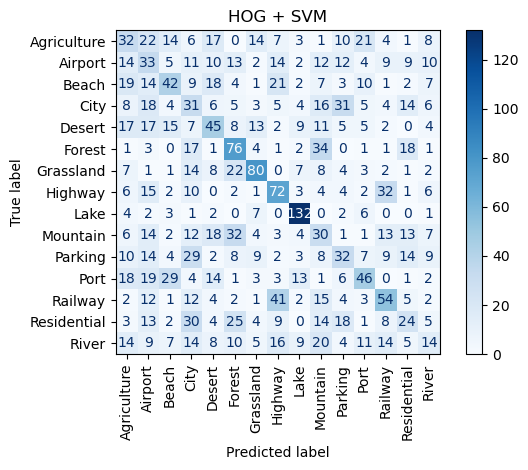

In [10]:
X_train_hog = extract_features(X_train_imgs, method='HOG')
X_test_hog = extract_features(X_test_imgs, method='HOG')
train_and_evaluate(X_train_hog, y_train, X_test_hog, y_test, SVC(kernel='linear'), "HOG + SVM")

### 2. HOG + KNN


==== Model: HOG + KNN ====
              precision    recall  f1-score   support

 Agriculture       1.00      0.00      0.00       160
     Airport       1.00      0.01      0.02       160
       Beach       1.00      0.01      0.02       160
        City       0.00      0.00      0.00       160
      Desert       0.28      0.11      0.15       160
      Forest       0.08      0.97      0.14       160
   Grassland       0.22      0.29      0.25       160
     Highway       0.22      0.01      0.02       160
        Lake       0.97      0.19      0.32       160
    Mountain       0.00      0.00      0.00       160
     Parking       0.25      0.01      0.01       160
        Port       0.00      0.00      0.00       160
     Railway       0.78      0.13      0.22       160
 Residential       1.00      0.00      0.00       160
       River       1.00      0.01      0.01       160

    accuracy                           0.12      2400
   macro avg       0.52      0.12      0.08      240

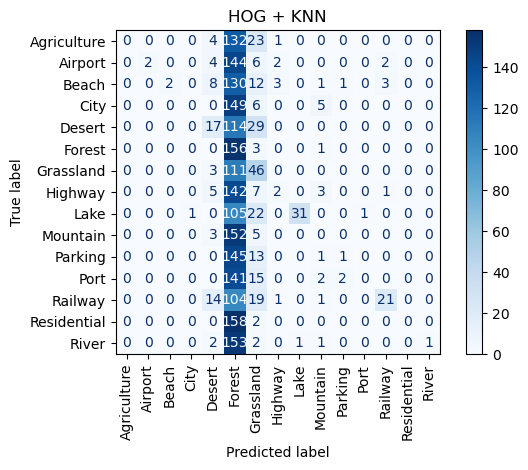

In [12]:
train_and_evaluate(X_train_hog, y_train, X_test_hog, y_test, KNeighborsClassifier(n_neighbors=5), "HOG + KNN")

### 3. LBP + SVM


==== Model: LBP + SVM ====
              precision    recall  f1-score   support

 Agriculture       0.19      0.62      0.30       160
     Airport       0.16      0.11      0.13       160
       Beach       0.32      0.16      0.21       160
        City       0.11      0.28      0.15       160
      Desert       0.54      0.04      0.08       160
      Forest       0.17      0.81      0.28       160
   Grassland       0.80      0.03      0.05       160
     Highway       1.00      0.00      0.00       160
        Lake       0.50      0.06      0.11       160
    Mountain       0.00      0.00      0.00       160
     Parking       0.12      0.07      0.09       160
        Port       0.44      0.48      0.46       160
     Railway       0.20      0.02      0.03       160
 Residential       0.05      0.06      0.06       160
       River       0.03      0.01      0.01       160

    accuracy                           0.18      2400
   macro avg       0.31      0.18      0.13      240

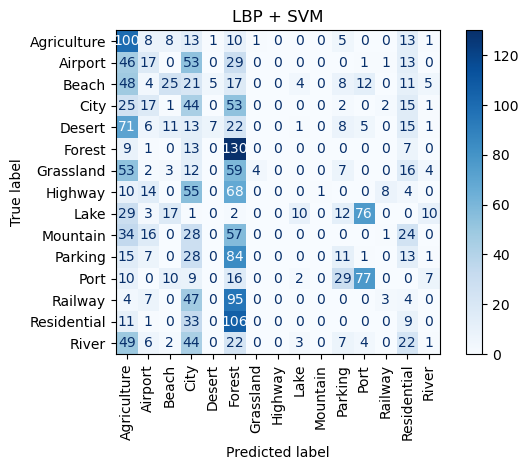

In [14]:
X_train_lbp = extract_features(X_train_imgs, method='LBP')
X_test_lbp = extract_features(X_test_imgs, method='LBP')
train_and_evaluate(X_train_lbp, y_train, X_test_lbp, y_test, SVC(kernel='linear'), "LBP + SVM")

### 4. LBP + KNN


==== Model: LBP + KNN ====
              precision    recall  f1-score   support

 Agriculture       0.28      0.46      0.35       160
     Airport       0.14      0.21      0.17       160
       Beach       0.27      0.31      0.29       160
        City       0.19      0.24      0.21       160
      Desert       0.47      0.28      0.35       160
      Forest       0.75      0.81      0.78       160
   Grassland       0.76      0.62      0.69       160
     Highway       0.26      0.17      0.20       160
        Lake       0.44      0.37      0.40       160
    Mountain       0.31      0.34      0.32       160
     Parking       0.38      0.30      0.34       160
        Port       0.58      0.69      0.63       160
     Railway       0.38      0.37      0.38       160
 Residential       0.32      0.32      0.32       160
       River       0.24      0.12      0.16       160

    accuracy                           0.37      2400
   macro avg       0.39      0.37      0.37      240

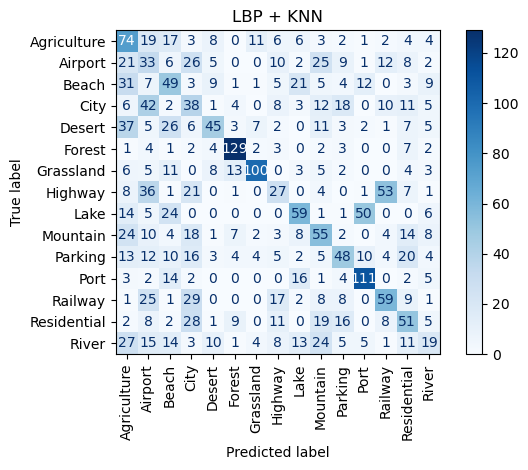

In [16]:
train_and_evaluate(X_train_lbp, y_train, X_test_lbp, y_test, KNeighborsClassifier(n_neighbors=5), "LBP + KNN")